In [1]:
import torch
from sklearn.metrics import mean_squared_error
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference.potentials import posterior_estimator_based_potential
from sbi.samplers.rejection import rejection
from sbi.utils.user_input_checks import process_prior as sbi_process_prior


from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import datetime
from torch.distributions import Distribution 

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import time
from torch.distributions import MultivariateNormal
from dataclasses import dataclass, fields, field

c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
pathos = True
try:
    from pathos.multiprocessing import ProcessPool as Pool
except ImportError:
    print('You could install pathos to enable parallel simulation.')
    pathos = False

In [18]:
@dataclass
class ParamPriors:
    kmax: tuple = (0.01, 0.1)
    kmin: tuple = (0.0, 0.05)
    b: tuple = (0.5, 1.0)
    d: tuple = (0.05, 0.5)
    kabs: tuple = (0.01, 1.5)
    kp1: tuple = (3.0, 12.0)
    kp2: tuple = (0.0, 0.05)
    kp3: tuple = (0.0, 0.05)
    k1: tuple = (0.01, 0.2)
    k2: tuple = (0.01, 0.5)
    Vm0: tuple = (1.0, 15.0)
    Vmx: tuple = (0.01, 0.2)
    ka1: tuple = (0.001, 0.01)
    ka2: tuple = (0.01, 0.05)
    m1: tuple = (0.1, 0.5)
    m2: tuple = (0.1, 0.5)
    m30: tuple = (0.1, 1.0)
    m4: tuple = (0.05, 0.2)
    ki: tuple = (0.0, 0.05)
    p2u: tuple = (0.01, 0.1)
    Ib: tuple = (80.0, 140.0)
    kd: tuple = (0.01, 0.03)
    ksc: tuple = (0.05, 0.2)
print('n_params = ', len(fields(ParamPriors)))

n_params =  23


In [4]:
def get_patient_params(env):
    param_names = [f.name for f in fields(ParamPriors)]
    params = [getattr(env.env.patient._params, param) for param in param_names]
    return dict(zip(param_names, params))

In [5]:
@dataclass
class DeafultSimulationEnv:
   patient_name: str = 'adolescent#002'
   sensor_name: str = 'Dexcom'
   pump_name: str = 'Insulet'
   scenario: list[tuple[int,int]] = field(default_factory=lambda: [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)])
   hours: int = 24  # hours to simulate

In [6]:
priors = ParamPriors()

priors = ParamPriors()

# get the names and default values of the parameters using fields
param_names = [field.name for field in fields(priors)]
param_values = [field.default for field in fields(priors)]

print(param_names)
print(param_values)

['kmax', 'kmin', 'b', 'd', 'kabs', 'kp1', 'kp2', 'kp3', 'k1', 'k2', 'Vm0', 'Vmx', 'ka1', 'ka2', 'm1', 'm2', 'm30', 'm4', 'ki', 'p2u', 'Ib', 'kd', 'ksc']
[(0.01, 0.1), (0.0, 0.05), (0.5, 1.0), (0.05, 0.5), (0.01, 1.5), (3.0, 12.0), (0.0, 0.05), (0.0, 0.05), (0.01, 0.2), (0.01, 0.5), (1.0, 15.0), (0.01, 0.2), (0.001, 0.01), (0.01, 0.05), (0.1, 0.5), (0.1, 0.5), (0.1, 1.0), (0.05, 0.2), (0.0, 0.05), (0.01, 0.1), (80.0, 140.0), (0.01, 0.03), (0.05, 0.2)]


In [7]:
def process_uniform_priors(priors: ParamPriors) -> Distribution:
    """Converts a ParamPriors object to a tuple of torch.distributions.Uniform objects.

    Parameters
    ----------
    priors : ParamPriors
        A DataClass object containing the prior ranges for the parameters.

    Returns
    -------
    tuple
        
    """
    return sbi_process_prior(
        [
            torch.distributions.Uniform(
                torch.tensor([field.default[0]]), torch.tensor([field.default[1]]),
            )
            for field in fields(priors)
        ]
    )[0]

In [8]:
prior = process_uniform_priors(priors = ParamPriors())

C:\Users\bythe\AppData\Local\Temp\ipykernel_11440\3183933013.py:14: UserWarning: Prior was provided as a sequence of 23 priors. They will be interpreted as independent of each other and matched in order to the components of the parameter.
  return sbi_process_prior(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\utils\user_input_checks.py:85: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  return process_pytorch_prior(prior)


In [9]:
def load_default_simulation_env(env_settings: DeafultSimulationEnv = DeafultSimulationEnv(), hours:int =24) -> T1DSimEnv:
    """Load the default simulation environment.

    Parameters
    ----------
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.

    Returns
    -------
    T1DSimEnv
        The simulation environment object.
    """
    now = datetime.now()
    start_time = datetime.combine(now.date(), datetime.min.time())
    
    patient = T1DPatient.withName(env_settings.patient_name)
    sensor = CGMSensor.withName(env_settings.sensor_name, seed = 1)
    pump = InsulinPump.withName(env_settings.pump_name)
    scenario = CustomScenario(start_time=start_time, scenario=env_settings.scenario)
    controller = BBController()
    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=scenario)
    
    return SimObj(env = env, controller = controller, sim_time = timedelta(hours=hours), animate=False)

In [10]:
def set_custom_params(patient, custom_params):
    """_summary_

    Parameters
    ----------
    patient : _type_
        _description_
    custom_params : _type_
        _description_
    """
    param_names = [field.name for field in fields(ParamPriors())]
    for i, param in enumerate(param_names):
        setattr(patient._params, param, custom_params[i])

In [11]:
def create_simulation_envs_with_custom_params(params_sets: torch.Tensor, hours: int = 24) -> list[T1DSimEnv]:
    """_summary_

    Parameters
    ----------
    params_sets : torch.Tensor
        _description_

    Returns
    -------
    _type_
        _description_
    """
    default_simulation_env = load_default_simulation_env(hours = hours)

    simulation_envs = []
    for i in range(params_sets.shape[0]):
        custom_sim_env = deepcopy(default_simulation_env)
        patient_params = custom_sim_env.env.patient
        set_custom_params(patient_params, params_sets[i])
        simulation_envs.append(custom_sim_env)
    return simulation_envs

        
    

In [12]:
def simulate_glucose_dynamics(simulation_env: T1DSimEnv):
    """_summary_

    Parameters
    ----------
    simulation_env : T1DSimEnv
        _description_

    Returns
    -------
    _type_
        _description_
    """
    simulation_env.simulate()
    return simulation_env.results()['CGM'].values

In [13]:
def simulate_batch(simulations: list[T1DSimEnv]):
    """_summary_

    Parameters
    ----------
    simulations : list[T1DSimEnv]
        _description_

    Returns
    -------
    _type_
        _description_
    """
    tic = time.time()
    if pathos:
        with Pool() as p:
            print('Using pathos for parallel simulation.')
            results = p.map(simulate_glucose_dynamics, simulations)
    else:
        results = [simulate_glucose_dynamics(s) for s in tqdm(simulations)]
    toc = time.time()
    print('Simulation took {} sec.'.format(toc - tic))
    results = np.stack(results)
    return results

In [14]:
def run_glucose_simulator(params_sets: torch.Tensor, hours: int = 24):
    """_summary_

    Parameters
    ----------
    param_sets : torch.Tensor
        _description_
    hours : int, optional
        _description_, by default 24

    Returns
    -------
    _type_
        _description_
    """
    simulation_envs = create_simulation_envs_with_custom_params(params_sets = params_sets)
    results = simulate_batch(simulation_envs)
    return results

In [19]:
def set_up_sbi_simulator(priors: ParamPriors = ParamPriors(), glucose_simulator: callable = run_glucose_simulator) -> callable:
    """_summary_

    Parameters
    ----------
    priors : ParamPriors, optional
        _description_, by default ParamPriors()
    glucose_simulator : callable, optional
        _description_, by default run_glucose_simulator

    Returns
    -------
    callable
        _description_
    """
    processed_priors = process_uniform_priors(priors = priors)
    sbi_sumulator = process_simulator(glucose_simulator, processed_priors, False)
    check_sbi_inputs(sbi_sumulator, prior)
    return sbi_sumulator

In [20]:
sbi_simulator = set_up_sbi_simulator()

C:\Users\bythe\AppData\Local\Temp\ipykernel_11440\3183933013.py:14: UserWarning: Prior was provided as a sequence of 23 priors. They will be interpreted as independent of each other and matched in order to the components of the parameter.
  return sbi_process_prior(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\utils\user_input_checks.py:85: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  return process_pytorch_prior(prior)


Using pathos for parallel simulation.
Simulation took 21.11811113357544 sec.
Using pathos for parallel simulation.
Simulation took 16.29920768737793 sec.


In [21]:
def get_true_observation(hours: int = 24) -> tuple[np.ndarray, dict]:
    """ Returns the single glucose dynamcis simulation from the default simulation environment parameters and these parameters.

    Returns
    -------
    np.ndarray
        Time series of glucose dynamics.
    """
    default_simulation_env = load_default_simulation_env(hours=hours)
    default_simulation_env.simulate()
    true_params = get_patient_params(default_simulation_env)
    true_observation = default_simulation_env.results()['CGM'].to_numpy()
    return true_observation, true_params

In [22]:
def run_APT(prior: Distribution, simulator: callable, true_observation: np.ndarray, num_rounds: int = 10, num_simulations: int = 1000):
    """_summary_

    Parameters
    ----------
    prior : Distribution
        _description_
    simulator : callable
        _description_
    num_rounds : int, optional
        _description_, by default 5
    num_simulations : int, optional
        _description_, by default 1000

    Returns
    -------
    _type_
        _description_
    """
    inference = NPE(prior)
    proposal = prior
    for _ in range(num_rounds):
        print('Running round: ', _, ' of ', num_rounds)
        theta = proposal.sample((num_simulations,))
        x = simulator(theta)
        _ = inference.append_simulations(theta, x, proposal=proposal).train()
        posterior_dist = inference.build_posterior().set_default_x(true_observation)
        proposal = posterior_dist
    return posterior_dist

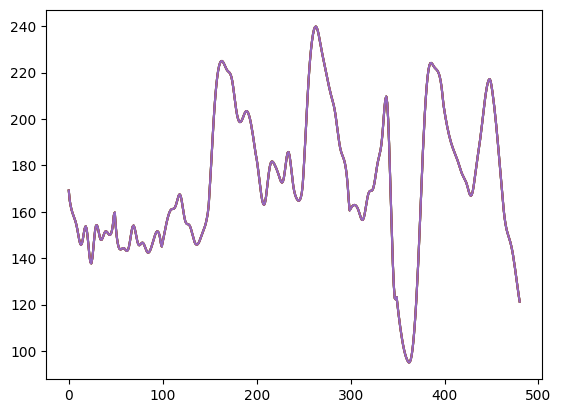

In [24]:
for i in range(5):
    true_observation, true_params = get_true_observation(hours = 24)
    plt.plot(true_observation)

In [ ]:
def sample_from_posterior(posterior: Distribution, x_true: np.ndarray, num_samples: int = 1000) -> torch.Tensor: 
    posterior_samples = posterior.sample((num_samples,), x=x_true)
    return posterior_samples

In [ ]:
posterior_dist = run_APT(prior, sbi_simulator, true_observation, num_rounds = 5, num_simulations = 200)

Using pathos for parallel simulation.


In [ ]:
#123